# Pyrenew demo
This demo simulates some basic renewal process data and then fits to it using `pyrenew`.

You'll need to install `pyrenew` first. You'll also need working installations of `matplotlib`, `numpy`, `jax`, `numpyro`, and `polars`

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.size"] = 10
mpl.rcParams["axes.formatter.use_mathtext"] = True
mpl.rcParams["axes.grid"] = True
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.left"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.bottom"] = False
mpl.rcParams["legend.fancybox"] = True
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.framealpha"] = 1

import jax
import jax.numpy as jnp
import numpy as np
from numpyro.handlers import seed
import numpyro.distributions as dist

/home/xrd4/.cache/pypoetry/virtualenvs/pyrenew-e8bt3r2y-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


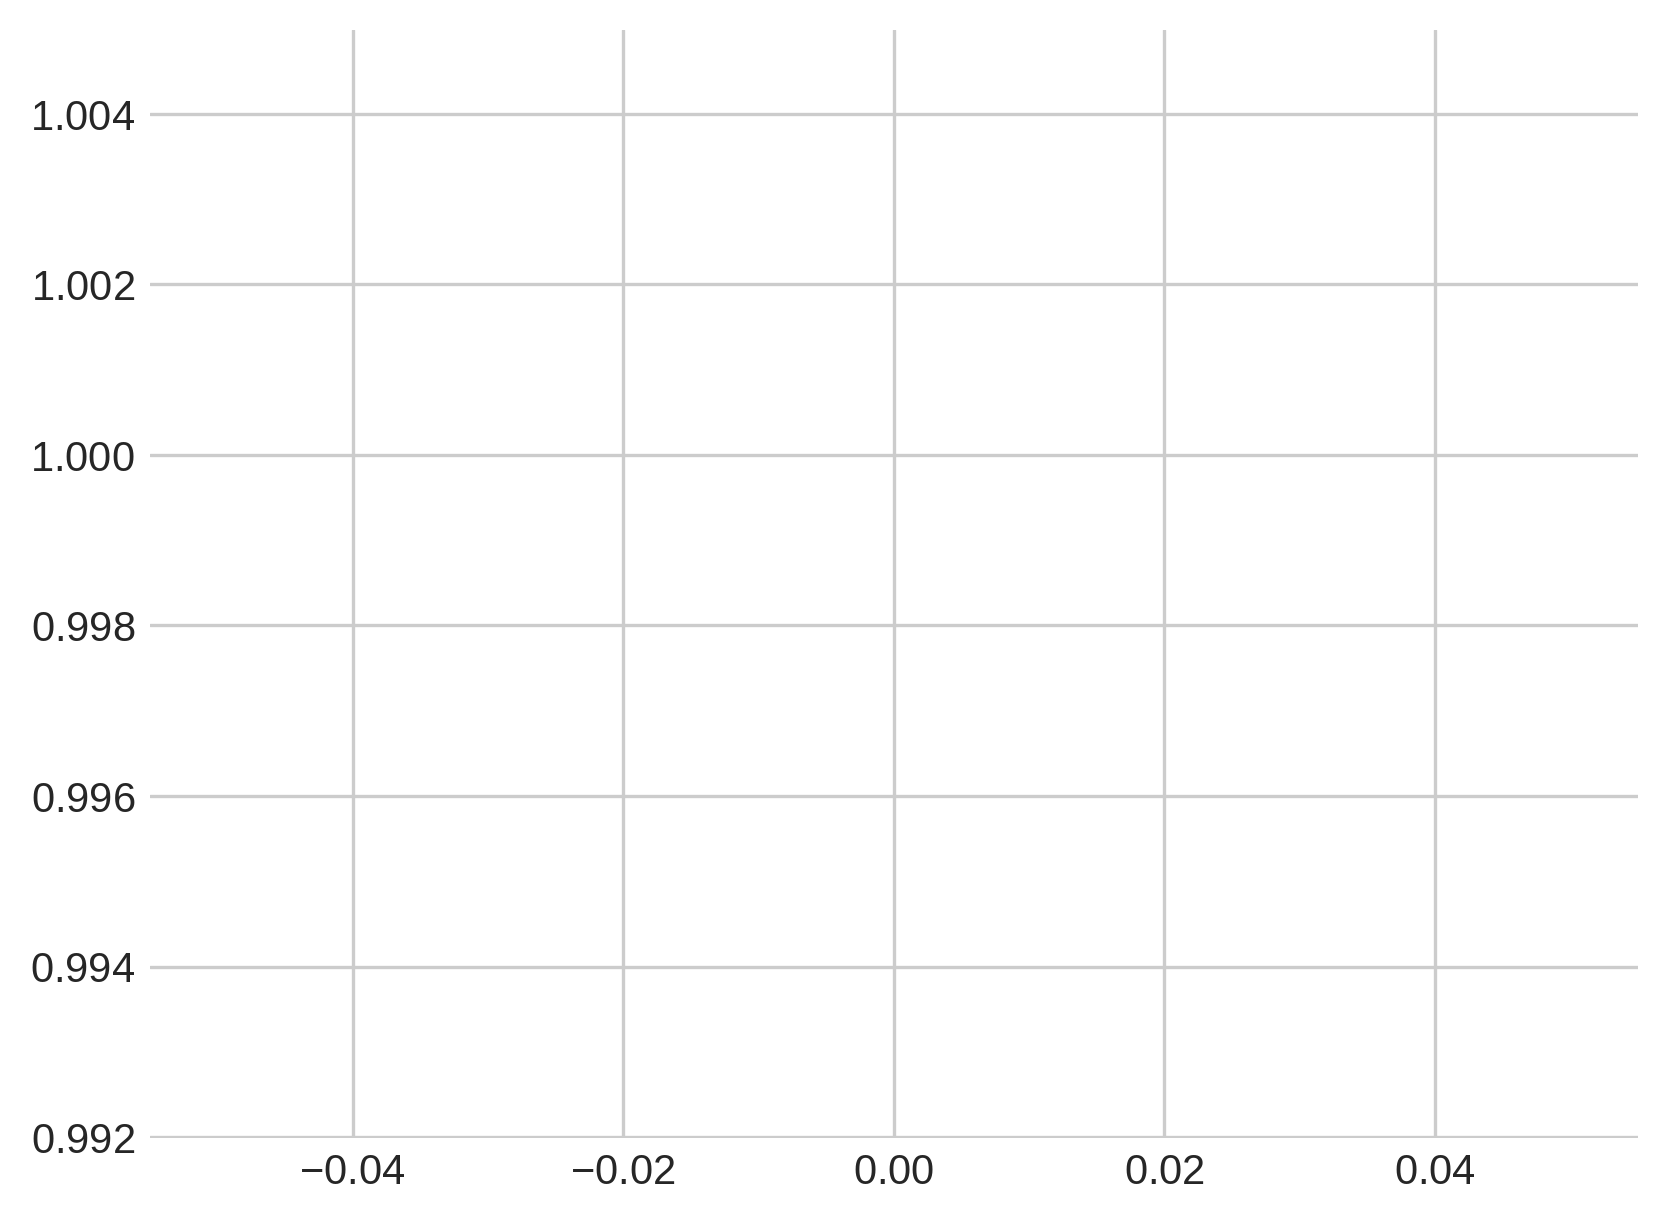

In [2]:
from pyrenew.processes import SimpleRandomWalkProcess

q = SimpleRandomWalkProcess(dist.Normal(0, 0.001))
with seed(rng_seed=np.random.randint(0,1000)):
    q_samp = q.sample(duration=100)
    
plt.plot(np.exp(q_samp))

In [3]:
from pyrenew.observations import (
    Infections,
    Hospitalizations,
    PoissonObservation
)

from pyrenew.models import HospitalizationsModel
from pyrenew.processes import RtRandomWalkProcess

# Initializing model parameters
infections_obs = Infections(jnp.array([0.25, 0.25, 0.25, 0.25]))
Rt_process = RtRandomWalkProcess()
hosp_obs = Hospitalizations(
    inf_hosp_int=jnp.array(
        [0, 0, 0,0,0,0,0,0,0,0,0,0,0, 0.25, 0.5, 0.1, 0.1, 0.05],
        ),
    infections_obs_varname='infections',
    hosp_dist=PoissonObservation(
        rate_varname='hospitalizations_predicted',
        counts_varname='hospitalizations_obs',
        )
)

# Initializing the model
hospmodel = HospitalizationsModel(
    Rt_process     = Rt_process,
    infections_obs = infections_obs,
    hosp_obs       = hosp_obs
    )

In [4]:
with seed(rng_seed=np.random.randint(1, 60)):
    x = hospmodel.sample(constants=dict(n_timepoints=30))
x

HospModelSample(Rt=Array([1.3650985, 1.3526884, 1.3655692, 1.3738946, 1.3643816, 1.3605493,
       1.3418797, 1.3374156, 1.4321394, 1.5253737, 1.5237479, 1.5246325,
       1.5455315, 1.5321434, 1.4939036, 1.5292739, 1.4688663, 1.4534245,
       1.431316 , 1.4047997, 1.4419293, 1.3963969, 1.3463113, 1.3528168,
       1.4239678, 1.5090842, 1.4708827, 1.483727 , 1.4679148, 1.4876609,
       1.5700654], dtype=float32), infect_sampled=Array([  3.2226214,   4.2831254,   5.786137 ,   7.8087983,   7.1973453,
         8.529082 ,   9.836435 ,  11.157944 ,  13.147328 ,  16.272224 ,
        19.20453  ,  22.786406 ,  27.591791 ,  32.88552  ,  38.26942  ,
        46.464363 ,  53.32392  ,  62.113266 ,  71.62698  ,  82.015205 ,
        96.99836  , 109.18211  , 121.10832  , 138.42834  , 165.79156  ,
       201.65529  , 230.5548   , 273.16525  , 319.69968  , 381.24103  ,
       472.849    ], dtype=float32), IHR=Array(0.04801352, dtype=float32), pred_hosps=Array([0.        , 0.        , 0.        , 0.   

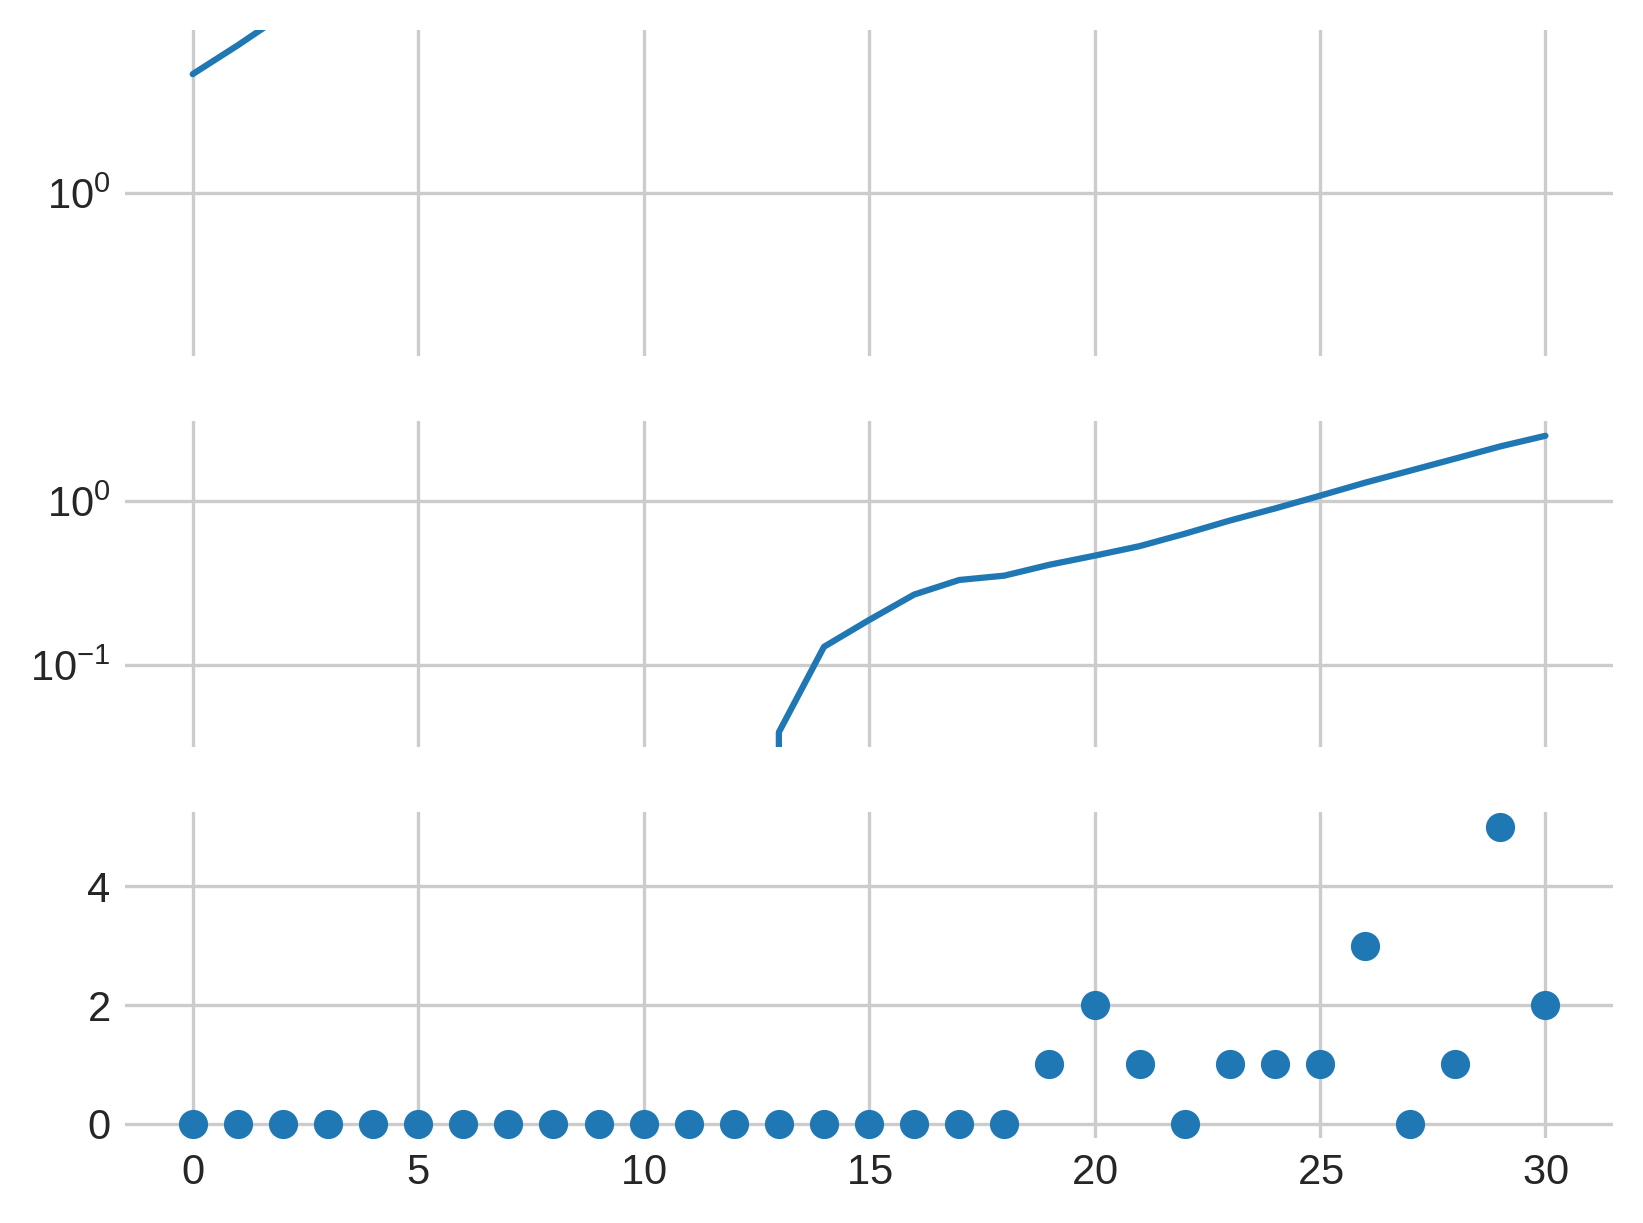

In [5]:
fig, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(x.infect_sampled)
ax[0].set_ylim([1/5, 5])
ax[1].plot(x.pred_hosps)
ax[2].plot(x.samp_hosp, 'o')
for axis in ax[:-1]:
    axis.set_yscale("log")

In [6]:
sim_dat={"hospitalizations_obs": x.samp_hosp}
constants = {"n_timepoints":len(x.samp_hosp)-1}

# from numpyro.infer import MCMC, NUTS
hospmodel.run(
    num_warmup=1000,
    num_samples=1000,
    random_variables=sim_dat,
    constants=constants,
    rng_key=jax.random.PRNGKey(54),
    )

sample: 100%|██████████| 2000/2000 [00:02<00:00, 780.85it/s, 7 steps of size 4.10e-01. acc. prob=0.90]  


In [7]:
hospmodel.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
                         I0      8.24      1.98      8.05      5.23     11.69   1170.70      1.00
                        IHR      0.05      0.00      0.05      0.05      0.05   1742.89      1.00
                        Rt0      1.44      0.10      1.44      1.28      1.61    996.47      1.00
 Rt_transformed_rw_diffs[0]      0.00      0.02      0.00     -0.03      0.05   1427.37      1.00
 Rt_transformed_rw_diffs[1]      0.00      0.02      0.00     -0.04      0.04   1165.39      1.00
 Rt_transformed_rw_diffs[2]      0.00      0.02      0.00     -0.03      0.04   1428.07      1.00
 Rt_transformed_rw_diffs[3]      0.00      0.02      0.00     -0.04      0.04   2036.30      1.00
 Rt_transformed_rw_diffs[4]      0.00      0.02      0.00     -0.03      0.05   1246.63      1.00
 Rt_transformed_rw_diffs[5]      0.00      0.03      0.00     -0.04      0.04   1485.77      1.00
 Rt_transformed_rw_

In [8]:
from pyrenew.mcmcutils import spread_draws
samps = spread_draws(hospmodel.mcmc.get_samples(), [("Rt", "time")])

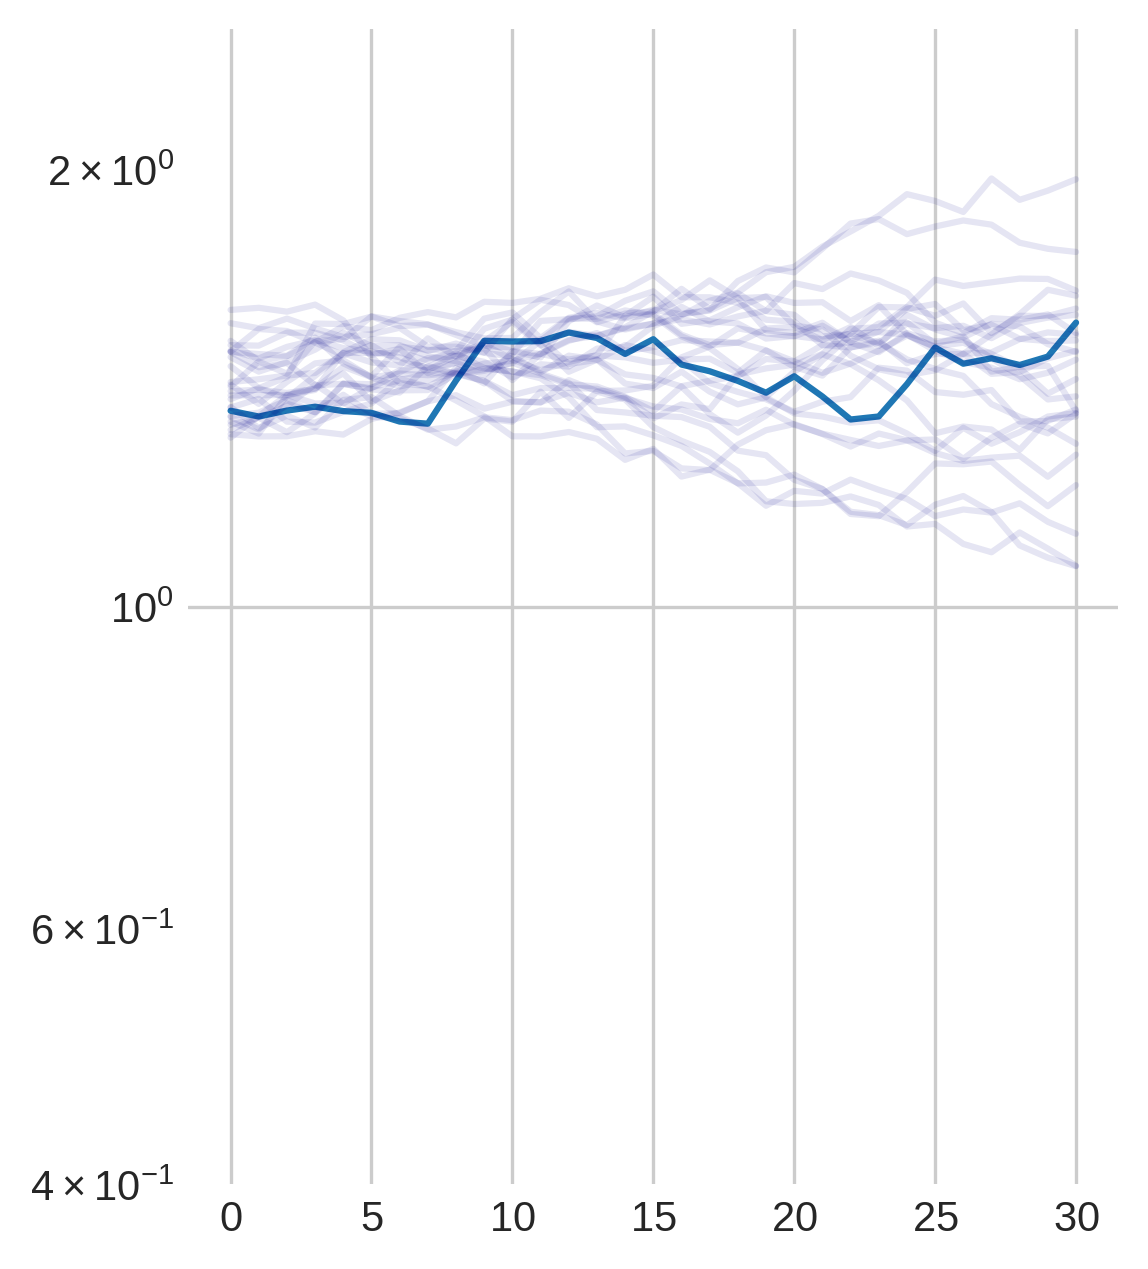

In [9]:
import numpy as np
import polars as pl
fig, ax = plt.subplots(figsize=[4, 5])

ax.plot(x[0])
samp_ids = np.random.randint(size=25, low=0, high=999)
for samp_id in samp_ids:
    sub_samps = samps.filter(pl.col("draw") == samp_id).sort(pl.col('time'))
    ax.plot(sub_samps.select("time").to_numpy(), 
            sub_samps.select("Rt").to_numpy(), color="darkblue", alpha=0.1)
ax.set_ylim([0.4, 1/.4])
ax.set_yticks([0.5, 1, 2])
ax.set_yscale("log")
